In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# neural network layer
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        

        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        

        
# softmax activation function
class softmax:
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs)
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
    def backward(self,dinputs):

        
        # initialized gradient array
        self.dinputs = np.zeros(dinputs.shape)
        
        # For each data point, compute gradient
        for i in range(len(dinputs)):
            
            # probabilities 
            proba = self.output[i]
            
            # loss gradients
            dinputs_row = dinputs[i]


            # calculate derivative matrix of the output
            derivative_matrix = np.diag(proba) - proba.reshape(-1,1).dot(proba.reshape(1,-1))
            
            # store gradient
            self.dinputs[i] = dinputs_row.dot(derivative_matrix)
            

class loss_crossentropy():
    
    def forward(self, y_hat, y):
        
        # number of data points
        n_samples = len(y)
        
        # clip data to prevent division by 0
        y_hat_clipped = np.clip(y_hat, 1e-7,1 - 1e-7)
        
        # predicted class probabilities
        pred_proba = y_hat_clipped[range(n_samples),y]
       
        # sample losses 
        losses = -np.log(pred_proba)
        
        return losses
    
    
    def backward(self, p, y):
        
        
        # number of samples
        n_samples = len(y)
    
        # one-hot matrix
        Y = np.zeros(p.shape)
        Y[np.arange(len(y)),y] = 1
        
        # calculate gradient
        self.dinputs = -Y / p
        
        # normalized gradient
        self.dinputs = self.dinputs / n_samples
            
            
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases

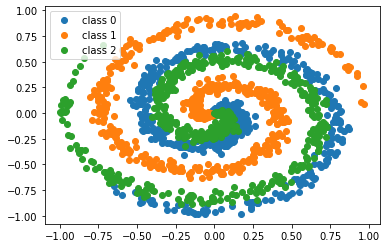

In [4]:
# generate toy dataset
classes = 3
n_points = 500
noise = 0.35
radius = 10

X = np.zeros((n_points*classes, 2))
y = np.zeros(n_points*classes).astype('int')

for class_number in range(classes):
    ix = range(n_points*class_number, n_points*(class_number+1))
    r = np.linspace(0,1, n_points)
    t = np.linspace(class_number*radius, (class_number+1)*radius, n_points) + np.random.randn(n_points)*noise
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = class_number
    
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o',label = 'class '+str(i))
plt.legend()

In [5]:
# build neural network

# layer 1
layer1 = layer(n_inputs = 2, n_neurons = 64)
activation1 = ReLU()

# layer 2
layer2 = layer(n_inputs = 64, n_neurons = 64)
activation2 = ReLU() 

# layer 3 
layer3 = layer(n_inputs = 64, n_neurons = classes)
activation3  = softmax()

# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_GD(learning_rate = 1)

In [6]:
n_epochs = 2000
error = np.zeros(n_epochs)
y_pred = np.zeros(y.shape)

# gradient descent iterations
for epoch in range(n_epochs):

    # forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)

    # loss (mean squared error)
    losses = loss_function.forward(activation3.output,y)


    # backward pass
    loss_function.backward(activation3.output,y)
    activation3.backward(loss_function.dinputs)
    layer3.backward(activation3.dinputs)
    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    
    # update weights and biases
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)


    
    # print loss and accuracy (every 100 epochs)
    if epoch % 100 == 0:
        # loss
        loss = np.round(np.mean(losses),3)
        # accuracy (percentage of correct classifications)
        y_pred = np.argmax(activation3.output,axis=1)
        accuracy = np.round(100*np.mean(y==y_pred),3)
        print('epoch: '+str(epoch))
        print('loss: '+str(np.round(np.mean(losses),3)))
        print('accuracy: '+str(accuracy))
        print('------------------------')

epoch: 0
loss: 1.098
accuracy: 33.333
------------------------
epoch: 100
loss: 1.059
accuracy: 44.4
------------------------
epoch: 200
loss: 1.054
accuracy: 45.2
------------------------
epoch: 300
loss: 1.045
accuracy: 45.2
------------------------
epoch: 400
loss: 1.025
accuracy: 40.4
------------------------
epoch: 500
loss: 0.982
accuracy: 48.0
------------------------
epoch: 600
loss: 0.885
accuracy: 57.2
------------------------
epoch: 700
loss: 0.708
accuracy: 67.867
------------------------
epoch: 800
loss: 0.598
accuracy: 70.8
------------------------
epoch: 900
loss: 0.475
accuracy: 77.4
------------------------
epoch: 1000
loss: 0.41
accuracy: 78.067
------------------------
epoch: 1100
loss: 0.356
accuracy: 84.733
------------------------
epoch: 1200
loss: 0.317
accuracy: 85.4
------------------------
epoch: 1300
loss: 0.305
accuracy: 87.333
------------------------
epoch: 1400
loss: 0.3
accuracy: 85.6
------------------------
epoch: 1500
loss: 0.275
accuracy: 89.6
------

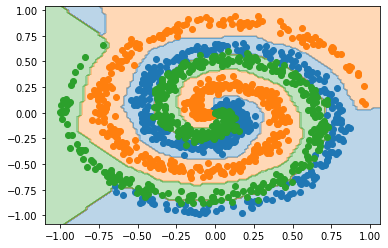

In [7]:
# plot classification regions
from matplotlib.colors import ListedColormap
# step size
h = 0.02

# mesh grid
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
X_plot = np.c_[xx.ravel(),yy.ravel()]

# forward pass
layer1.forward(X_plot)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)
layer3.forward(activation2.output)
activation3.forward(layer3.output)


# predictions
y_pred = activation3.output
y_plot = np.argmax(y_pred, axis=1)
y_plot = y_plot.reshape(xx.shape)

# classification regions
my_cmap = ListedColormap(['C'+str(i) for i in range(classes)])
plt.contourf(xx, yy, y_plot, cmap=my_cmap, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# dataset
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o')